# A simple 2D Flow Matching model

This notebook trains and evaluates a simple 2D FM model with CondOT (i.e., linear) scheduler.

Dataset: 2D checkerboard
Model (velocity): MLP

## Imports and init device

In [37]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from peft import LoraConfig, get_peft_model
from sklearn.datasets import make_moons


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [38]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [39]:
torch.manual_seed(42)

## Dataset

In [40]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    
    return data.float()
def train_moon_gen(batch_size: int = 200, device: str = "cpu", is_pretrain: bool = False):
    full_x, full_y = make_moons(n_samples=batch_size * 2, noise=0, random_state=42)
    if is_pretrain:
        return torch.tensor(full_x[:batch_size], dtype=torch.float32, device=device)
    else:
        return torch.tensor(full_x[full_y == 1][:batch_size], dtype=torch.float32, device=device)

## Model

In [41]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)
# reinit lora utils, loraGA
from tqdm import tqdm
from peft.tuners.lora import LoraLayer
@torch.no_grad()
def reinit_lora_modules(name, module, gamma, named_grad):
    # r"""
    # Reinitialize the lora model with the given configuration.
    # """
    lora_r = 2


    # print("*************************")
    
    # grad_name = name + '.weight'
    grad_name = ".".join(name.split(".")[-2:]) + '.weight'
    # print(grad_name)
    grads = named_grad[grad_name]

    grads = -grads.cuda().float()
    m, n = grads.shape

    grads = grads * (m**0.5)
    U, S, V = torch.linalg.svd(grads)
    B = U[:, :lora_r] @ torch.diag(torch.sqrt(S[:lora_r])) / torch.sqrt(S[0])
    A = torch.diag(torch.sqrt(S[:lora_r])) @ V[:lora_r, :] / torch.sqrt(S[0])
    B = B / gamma**0.5
    A = A / gamma**0.5

    module.lora_B.default.weight = torch.nn.Parameter(B.contiguous().cuda())
    module.lora_A.default.weight = torch.nn.Parameter(A.contiguous().cuda())
    return
    # lora_r = 2


    # # print("*************************")
    
    # # grad_name = name + '.weight'
    # grad_name = ".".join(name.split(".")[-2:]) + '.weight'
    # # print(grad_name)
    # grads = named_grad[grad_name]

    # m, n = grads.shape
    # # print(m,n)
    # U, S, V = torch.linalg.svd(grads.float())
    # B = U[:, lora_r : 2 * lora_r]
    # A = V[:lora_r, :]
    # m, n = grads.shape # m: feature_out, n: feature_in
    # # the scale of output is only related to the feature_out
    
    # B = B * m**0.25 / gamma**0.5
    # A = A * m**0.25 / gamma**0.5

    # module.lora_B.default.weight = torch.nn.Parameter(B.contiguous().cuda())
    # module.lora_A.default.weight = torch.nn.Parameter(A.contiguous().cuda())
    # return
def reinit_lora(model, gamma, named_grad):
    r"""
    Reinitialize the lora model with the given configuration.
    """
    inited_modules = []
    for name, module in tqdm(
        model.named_modules(),
        desc="Reinitializing Lora",
        total=len(list(model.named_modules())),
    ):
        
        if isinstance(module, LoraLayer):
            reinit_lora_modules(name, module, gamma, named_grad)

        pass
    return model


## Train Velocity Flow Matching model

In [42]:
import os

# training arguments
lr = 0.001
batch_size = 4096
iterations = 5
print_every = 1 
hidden_dim = 512
is_pre_train = False
is_lora = False
is_eval = True
# velocity field model init
if not is_eval:
    vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 

    # instantiate an affine path object
    path = AffineProbPath(scheduler=CondOTScheduler())
    if not is_pre_train:
        state_dict = torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_9999.pth", map_location=device)
        vf.load_state_dict(state_dict)
        if is_lora:
            lora_config = LoraConfig(
                r=2,
                lora_alpha=4,
                target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
            )
            vf = get_peft_model(vf, lora_config)
            # init optimizer (only optimize LoRA parameters)
            optim = torch.optim.Adam(vf.parameters(), lr=lr)
            optim.param_groups[0]['params'] = [p for n, p in vf.named_parameters() if 'lora_' in n]
        else:
            # init optimizer (optimize all parameters)
            optim = torch.optim.Adam(vf.parameters(), lr=lr)
        iterations = 5  # set iterations to 10000 for LoRA training
    else:
        # init optimizer (optimize all parameters)
        optim = torch.optim.Adam(vf.parameters(), lr=lr)


    # train
    start_time = time.time()
    loss_history = []
    for i in range(iterations):
        optim.zero_grad() 
        
        # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
        x_1 = train_moon_gen(batch_size=batch_size, device=device, is_pretrain=is_pre_train) # sample data
        # x_0 = torch.randn_like(x_1).to(device)

        x_0, y = make_moons(n_samples=x_1.shape[0] * 3, noise=0.5, random_state=42)
        if is_pre_train:
            x_0 = torch.tensor(x_0[y == 0][:x_1.shape[0]]).float().to(device)  # use only one class for pre-training
        else:
            x_0 = torch.tensor(x_0[y == 1][:x_1.shape[0]]).float().to(device)

        # sample time (user's responsibility)
        t = torch.rand(x_1.shape[0]).to(device)
        

        # sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

        # flow matching l2 loss
        loss = torch.pow(vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
        loss_history.append(loss.item())
        # optimizer step
        loss.backward() # backward
        optim.step() # update
        
        # log loss
        if (i+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
                .format(i+1, elapsed*1000/print_every, loss.item())) 
            start_time = time.time()
            if not is_pre_train:
                if is_lora:
                    save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_{i+1}"
                    os.makedirs(save_path, exist_ok=True)
                    vf.save_pretrained(save_path)
                    pass
                else:
                    save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/full_model_{i}.pth"
                    if not os.path.exists(os.path.dirname(save_path)):
                        os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    torch.save(vf.state_dict(), save_path)
            else:
                save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_{i}.pth"
                if not os.path.exists(os.path.dirname(save_path)):
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                torch.save(vf.state_dict(), save_path)


In [43]:
if not is_eval:
    plt.figure(figsize=(8, 4))
    plt.plot(loss_history[:])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.show()

In [ ]:
is_reinit = False
is_lora = True
import pickle
from peft import LoraConfig, get_peft_model, PeftModel
if is_eval:
    if not is_reinit:
        # load the model
        if is_lora:
            vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
            vf.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
            vf = PeftModel.from_pretrained(vf, "/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_8000")
        else:
            vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
            vf.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/full_model_1999.pth", map_location=device))
    else:
        # reinit the model
        vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
        vf.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
        lora_config = LoraConfig(
            r=2,
            lora_alpha=4,
            target_modules=["main.0", "main.2", "main.4", "main.6"],  # target Linear layers in MLP
            init_lora_weights="gaussian",
        )
        vf = get_peft_model(vf, lora_config)
        gamma = 9
        with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999.pkl', 'rb') as f:
            named_grad = pickle.load(f)
        _ = reinit_lora(vf, gamma, named_grad)
    

#### Sample from trained model

In [45]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [46]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

### Visualize the path

[[-3.8484342e-02  2.9178989e-01]
 [ 5.4473884e-02  2.2287838e-01]
 [           nan            nan]
 ...
 [ 5.5038072e-02  2.2212562e-01]
 [-2.5112698e+07 -3.4712881e+09]
 [ 6.1625165e-01 -1.4711106e+00]]


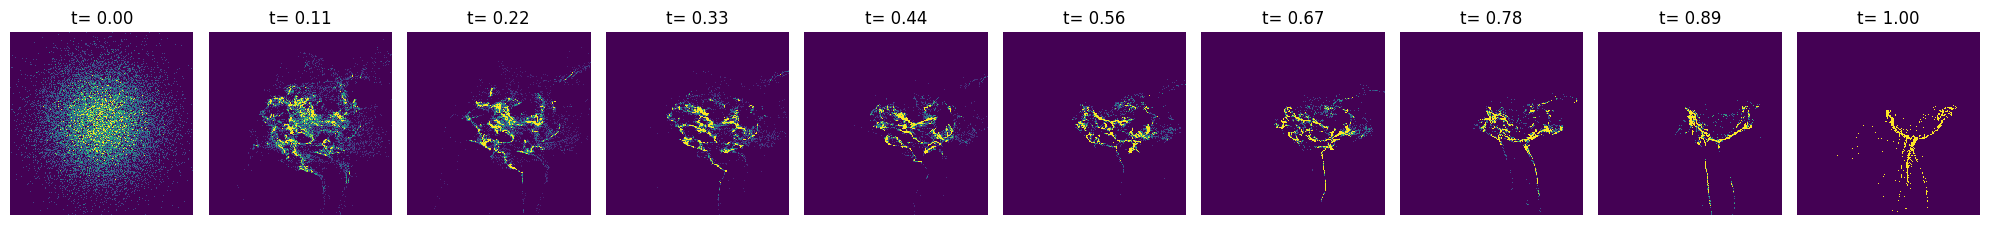

In [47]:
sol = sol.cpu().numpy()
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))
print(sol[9, :, :2])
for i in range(10):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-3,3), (-3,3)))
    
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-3,3), (-3,3)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

## Compute and Visualize Model Log-likelihood

In [48]:
from torch.distributions import Independent, Normal

In [49]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)
print(x_1.shape)

torch.Size([40000, 2])


In [50]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p

log_p_acc /= num_acc

# compute with exact divergence
_, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

ValueError: Expected value argument (Tensor of shape (40000, 2)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([2]), scale: torch.Size([2])), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0')

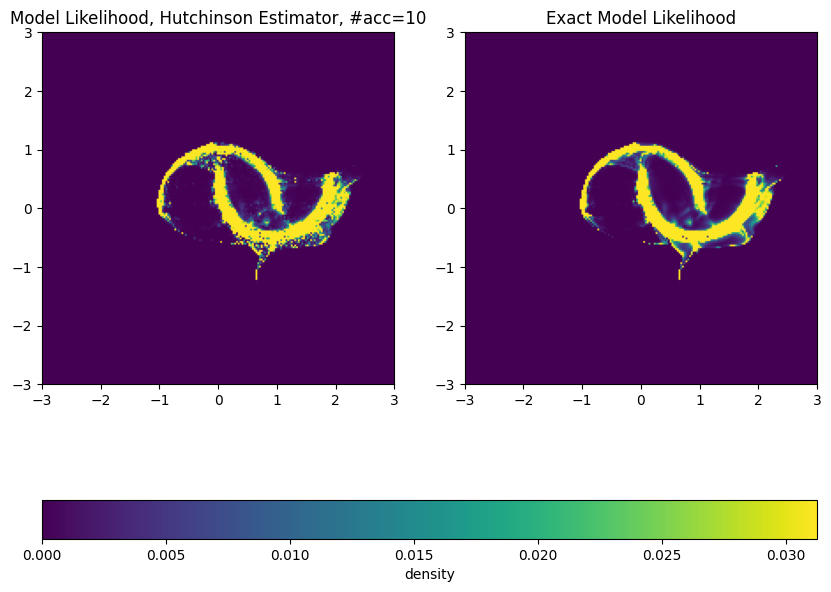

In [ ]:
likelihood = torch.exp(log_p_acc).cpu().reshape(grid_size, grid_size).t().detach().numpy()
exact_likelihood = torch.exp(exact_log_p).cpu().reshape(grid_size, grid_size).t().detach().numpy()

fig, axs = plt.subplots(1, 2,figsize=(10,10))

cmin = 0.0
cmax = 1/32 # 1/32 is the gt likelihood value

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

axs[0].imshow(likelihood, extent=(-3, 3, -3, 3), origin='lower', cmap='viridis', norm=norm)
axs[0].set_title('Model Likelihood, Hutchinson Estimator, #acc=%d' % num_acc)

axs[1].imshow(exact_likelihood, extent=(-3, 3, -3, 3), origin='lower', cmap='viridis', norm=norm)
axs[1].set_title('Exact Model Likelihood')

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs, orientation='horizontal', label='density')
plt.show()